<a href="https://colab.research.google.com/github/JasonYen-tw/CNN-Assignment-2025/blob/main/ACS111147_CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# --- CHANGE 1: 引入額外需要的函式庫 ---
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# --- CHANGE 1 END ---
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 載入CIFAR-10數據集
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# 正規化像素值到[0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# --- CHANGE 2: 將標籤進行 One-Hot Encoding ---
y_cat_train = to_categorical(train_labels, 10)
y_cat_test = to_categorical(test_labels, 10)

# 定義類別名稱
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


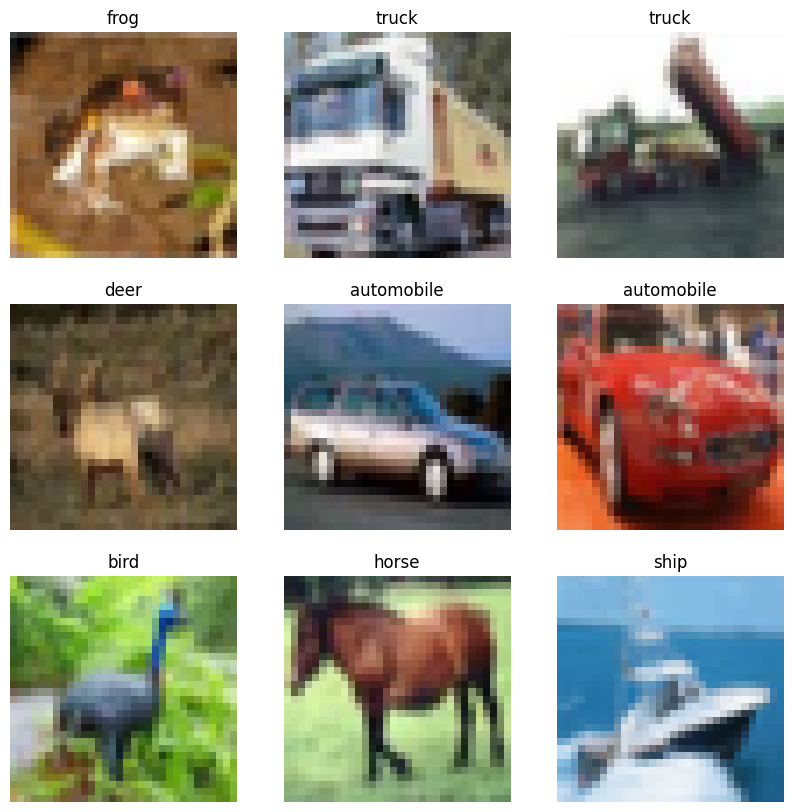

In [3]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.show()

In [4]:
# --- 極簡高效模型：專為速度和快速見效而設計 ---
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(), # 關鍵！穩定訓練，加速收斂
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), # 關鍵！
    layers.MaxPooling2D((2, 2)),

    # Block 3: 多加一層卷積來增強學習能力，但不增加太多複雜度
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), # 關鍵！

    # 分類層
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
# 顯示模型結構
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,818 (1.22 MB)

 Trainable params: 319,498 (1.22 MB)

 Non-trainable params: 320 (1.25 KB)

In [5]:
# --- CHANGE 4: (Task 2) 更新編譯設定 ---
# 更改 loss function 並加入 Precision 和 Recall 指標
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # <-- 從 sparse_categorical_crossentropy 改成這個
    metrics=['accuracy']
)
# --- CHANGE 4 END ---


In [6]:
# --- CHANGE 5: (Task 3) 加入資料增強並更新訓練方式 ---
# 1. 設定 ImageDataGenerator
batch_size = 32
data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 2. 建立訓練資料產生器
train_generator = data_generator.flow(train_images, y_cat_train, batch_size)

# 3. 使用產生器來訓練模型，並增加 epochs
history = model.fit(
    train_generator,
    epochs=10, # 在 10 個 Epochs 內完成訓練！
    validation_data=(test_images, y_cat_test)
)
# --- CHANGE 5 END ---

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 98ms/step - accuracy: 0.4228 - loss: 1.6279 - val_accuracy: 0.5047 - val_loss: 1.4373
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.6121 - loss: 1.0915 - val_accuracy: 0.6569 - val_loss: 0.9900
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 95ms/step - accuracy: 0.6666 - loss: 0.9470 - val_accuracy: 0.6880 - val_loss: 0.8794
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 100ms/step - accuracy: 0.7036 - loss: 0.8511 - val_accuracy: 0.6948 - val_loss: 0.8878
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 200s 99ms/step - accuracy: 0.7265 - loss: 0.7814 - val_accuracy: 0.6776 - val_loss: 0.9548
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.7369 - loss: 0.7447 - val_accuracy: 0.7279 - val_loss: 0.8162
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 96ms/step - accuracy: 0.7492 - loss: 0.7164 - val_accuracy: 0.6748 - val_loss: 0.9993
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.7635 - l

In [7]:
# 評估模型表現並寫入成績檔案（供自動評分用）
test_loss, test_acc = model.evaluate(test_images, y_cat_test, verbose=2)

with open('model_accuracy.txt', 'w') as f:
    f.write("Model Performance Summary:\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}\n")
    f.write(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final Training Loss: {history.history['loss'][-1]:.4f}\n")
    f.write(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}\n")
    f.write(f"Training Epochs: {len(history.history['accuracy'])}\n")
    f.write(f"Model Parameters: {model.count_params()}")

file = open('model_accuracy.txt', 'r')
print(f"\n{file.read()}")
file.close()

313/313 - 7s - 21ms/step - accuracy: 0.7661 - loss: 0.6878

Model Performance Summary:
Test Accuracy: 0.7661
Test Loss: 0.6878
Final Training Accuracy: 0.7780
Final Validation Accuracy: 0.7661
Final Training Loss: 0.6386
Final Validation Loss: 0.6878
Training Epochs: 10
Model Parameters: 319818


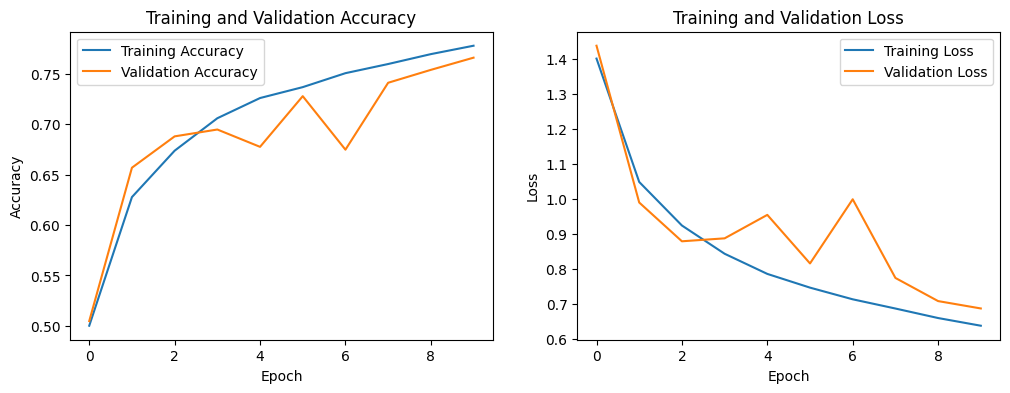

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 5: Report

1.  **關鍵技術：Batch Normalization**
    在每個 `Conv2D` 卷積層之後，我都加入了一個 `BatchNormalization` 層。它通過標準化每一層的輸出，極大地加速了模型的收斂速度並穩定訓練過程。

2.  **簡潔且有效的結構**
    模型主體由三個 `Conv-BN-Pool` 形式的區塊堆疊而成，同時 `padding='same'` 的設定也確保了特徵圖在傳遞過程中不會過快丟失邊緣資訊。